2022-03-15 10:30:01,280 WARN yarn.Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


[('merseybeat', 0.8404626846313477), ('piano rock', 0.6181025814806619), ('breakbeat hardcore', 0.6014364957809448), ('female artist', 0.5773162444223477), ('celtic punk', 0.5684918165206909), ('amherst', 0.5515524744987488), ('soul music', 0.5485217976989452), ('female fronted rock', 0.5444462895393372), ('liverpool', 0.5416024923324585), ('cante jondo', 0.5406306982040405), ('emo pop', 0.5319997366359237), ('rap metal', 0.5311322694239768), ('british trad rock', 0.5303163909887775), ('country music artist', 0.5290997530444839), ('thrash crossover', 0.5290395617485046), ('melodic thrash', 0.5290395617485046), ('thrash revival', 0.5290395617485046), ('jangle', 0.5287200839829886), ('dance pop', 0.5273767472914557), ('golden age', 0.5251976528695164)]


total execution time: 232.03407430648804
step 1 - initial spark session, execution time: 30.43980574607849
step 2 - read dataset, execution time: 3.8203132152557373
step 3 - computational experiment, execution time: 196.96657824516296


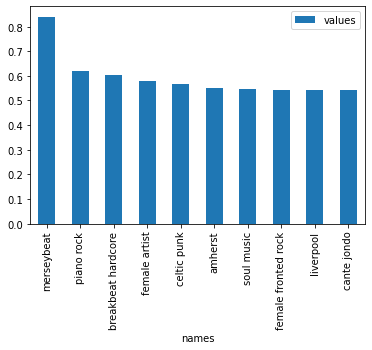

In [4]:
# This code is used for strong scaling analysis. The dataset is a 1GB CSV file. 
# The Spark configurations are changed according to the number of nodes (VMs) available.

# start timer
import time
script_start = time.time()

# Start step #1 - initial spark session
from pyspark.sql import SparkSession
from operator import add
import pyspark.sql.functions as f
from functools import reduce

# Use this code snippet if 1 node available
spark_session = SparkSession\
        .builder\
        .appName("dataAnalysis_duruo_test")\
        .config("spark.executor.instances", 3)\
        .config("spark.executor.memory", "1g")\
        .config("spark.executor.memoryOverhead", "2048")\
        .config("spark.executor.cores", 1)\
        .config("spark.driver.memory", "1g")\
        .config("spark.driver.memoryOverhead", "1024")\
        .config("spark.driver.cores", 1)\
        .config("spark.cores.max", 4)\
        .config("spark.dynamicAllocation.enabled", False)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled", False)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.shuffle.service.enabled", False)\
        .config("spark.driver.port",9998)\
        .config("spark.blockManager.port",10005)\
        .config("spark.sql.shuffle.partitions",5000)\
        .getOrCreate()

# Use this code snippet if 2 nodes available
# spark_session = SparkSession\
#         .builder\
#         .appName("dataAnalysis_duruo_test")\
#         .config("spark.executor.instances", 6)\
#         .config("spark.executor.memory", "1536m")\
#         .config("spark.executor.memoryOverhead", "3072")\
#         .config("spark.executor.cores", 1)\
#         .config("spark.driver.memory", "1g")\
#         .config("spark.driver.memoryOverhead", "1024")\
#         .config("spark.driver.cores", 1)\
#         .config("spark.cores.max", 4)\
#         .config("spark.dynamicAllocation.enabled", False)\
#         .config("spark.dynamicAllocation.shuffleTracking.enabled", False)\
#         .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
#         .config("spark.shuffle.service.enabled", False)\
#         .config("spark.driver.port",9998)\
#         .config("spark.blockManager.port",10005)\
#         .config("spark.sql.shuffle.partitions",5000)\
#         .getOrCreate()

# Use this code snippet if 3 nodes available
# spark_session = SparkSession\
#         .builder\
#         .appName("dataAnalysis_duruo_test")\
#         .config("spark.executor.instances", 10)\
#         .config("spark.executor.memory", "1638m")\
#         .config("spark.executor.memoryOverhead", "3072")\
#         .config("spark.executor.cores", 2)\
#         .config("spark.driver.memory", "1g")\
#         .config("spark.driver.memoryOverhead", "1024")\
#         .config("spark.driver.cores", 2)\
#         .config("spark.cores.max", 4)\
#         .config("spark.dynamicAllocation.enabled", False)\
#         .config("spark.dynamicAllocation.shuffleTracking.enabled", False)\
#         .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
#         .config("spark.shuffle.service.enabled", False)\
#         .config("spark.driver.port",9998)\
#         .config("spark.blockManager.port",10005)\
#         .config("spark.sql.shuffle.partitions",5000)\
#         .getOrCreate()

# Use this code snippet if 4 nodes available
# spark_session = SparkSession\
#         .builder\
#         .appName("dataAnalysis_duruo_test")\
#         .config("spark.executor.instances", 13)\
#         .config("spark.executor.memory", "1811m")\
#         .config("spark.executor.memoryOverhead", "3072")\
#         .config("spark.executor.cores", 1)\
#         .config("spark.driver.memory", "1g")\
#         .config("spark.driver.memoryOverhead", "1024")\
#         .config("spark.driver.cores", 1)\
#         .config("spark.cores.max", 4)\
#         .config("spark.dynamicAllocation.enabled", False)\
#         .config("spark.dynamicAllocation.shuffleTracking.enabled", False)\
#         .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
#         .config("spark.shuffle.service.enabled", False)\
#         .config("spark.driver.port",9998)\
#         .config("spark.blockManager.port",10005)\
#         .config("spark.sql.shuffle.partitions",5000)\
#         .getOrCreate()


script_step_1_end = time.time()
# End step #1 - initial spark session

# Start step #2 - read dataset
data_frame = spark_session.read.csv("hdfs://192.168.2.112:9000/user/ubuntu/million_song_dataset/million_song_subset_1gb_1.csv")
script_step_2_end = time.time()
# End step #2 - read dataset

# Start step #3 - computational experiment
def trim_genre(genre):
    """ UDF funtion that strips the genres of quotation marks and spaces. """
    return genre.strip(' ').strip('"')

def mapper(genres_and_hotness):
    """
    Mapper function used to pair hotness to genres. It pairs every genre in a list to an inputed hotness score.
    
    genres_and_hotness is a tuple that contains a list and a number.
    The list is a list of genres and the number is the hotness that each genre in the list is supposed to have.
    Here we pair that single hotness value to every genre in the list and return that.
    Example input: (['grunge', 'rock', 'pop'], 0.5)
    Example output: (('grunge', 0.5), ('rock', 0.5), ('pop', 0.5))
    """
    
    # genres_and_hotness[0] is a list of genres
    # genres_and_hotness[1] is the hotness score
    return ((genre, genres_and_hotness[1]) for genre in genres_and_hotness[0])

# Create trim_genre udf
trim_genre = f.udf(trim_genre)

# Get list of genres for a single artist (_c17) and trim that list.
# get also the hotness for that artist (_c2)
# Filter out the line that contains 'artist_terms' (that is only the first line)
# Convert the hotness column from string to float
# map it.
genres_and_hotness_df = data_frame.select(f.split(trim_genre(data_frame['_c17']), '" "'), '_c2')\
                        .filter(data_frame['_c17'] != 'artist_terms')\
                        .withColumn('_c2', data_frame['_c2'].cast('float').alias('_c2'))\
                        .rdd.map(lambda x: x)

# Create a flatmap of genre and hotness pairs.
mappings = genres_and_hotness_df.flatMap(mapper)

# map the genres, so we can count how often they appear
# reduceByKey is summing up the values of the hotness for each genre and also summing up how often each genre appears.
# filter is filtering out genres that appear too infrequently.
# mapValues is creating the average by dividing the sum of the hotness values with the count of how often a genre appears.
avg_rdd = mappings.mapValues(lambda x: (x, 1))\
                  .reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))\
                  .filter(lambda x: x[1][1] > 1000)\
                  .mapValues(lambda x: x[0] / x[1])

# ordering it to return the highest valued genres first.
print(avg_rdd.takeOrdered(20, key=lambda x: -x[1]))

import pandas as pd
data_list = avg_rdd.takeOrdered(10, key=lambda x: -x[1])
plot_data = pd.DataFrame({'names': [x[0] for x in data_list], 'values': [x[1] for x in data_list]})
plot_data.plot.bar(x='names', y='values')

script_step_3_end = time.time()
# End step #3 - computational experiment

# Start step #4 - close spark session
# release the cores for another application!
spark_session.stop()
script_step_4_end = time.time()
# End step #4 - close spark session

print("total execution time: {}".format(script_step_4_end - script_start))
print("step 1 - initial spark session, execution time: {}".format(script_step_1_end - script_start))
print("step 2 - read dataset, execution time: {}".format(script_step_2_end - script_step_1_end))
print("step 3 - computational experiment, execution time: {}".format(script_step_3_end - script_step_2_end))